0:	learn: 0.5920104	test: 0.5894545	best: 0.5894545 (0)	total: 208ms	remaining: 1m 43s
50:	learn: 0.6744558	test: 0.6721058	best: 0.6723628 (49)	total: 2s	remaining: 17.6s
100:	learn: 0.6812226	test: 0.6765454	best: 0.6773532 (97)	total: 3.75s	remaining: 14.8s
150:	learn: 0.6845781	test: 0.6787021	best: 0.6787021 (150)	total: 5.57s	remaining: 12.9s
200:	learn: 0.6857475	test: 0.6801632	best: 0.6803025 (198)	total: 7.32s	remaining: 10.9s
250:	learn: 0.6873510	test: 0.6802669	best: 0.6804984 (247)	total: 9.06s	remaining: 8.99s
300:	learn: 0.6891426	test: 0.6809019	best: 0.6812960 (290)	total: 10.8s	remaining: 7.12s
350:	learn: 0.6905452	test: 0.6816252	best: 0.6820841 (346)	total: 12.5s	remaining: 5.31s
400:	learn: 0.6919736	test: 0.6824041	best: 0.6825179 (395)	total: 14.3s	remaining: 3.52s
450:	learn: 0.6936630	test: 0.6827686	best: 0.6829902 (443)	total: 16s	remaining: 1.74s
499:	learn: 0.6948034	test: 0.6831687	best: 0.6833921 (485)	total: 17.7s	remaining: 0us

bestTest = 0.683392144

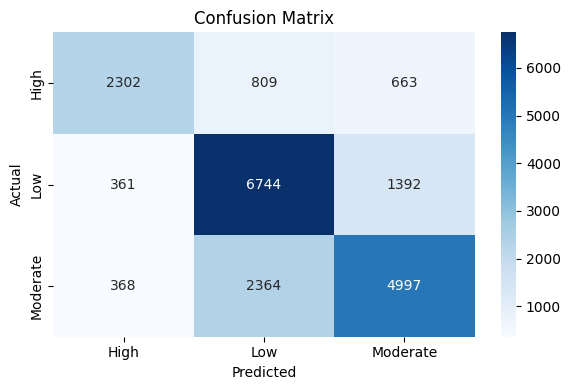

In [1]:
# STEP-0: Install if missing
# pip install catboost scikit-learn matplotlib seaborn

import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# STEP-1: Load data
df = pd.read_csv("D:\Realistic_Significant_Diabetes_100K_TrulyUnique.csv")
df = df.drop(columns=["PatientID"])  # Drop PatientID

# STEP-2: Encode target
le = LabelEncoder()
df['DiabeticRisk'] = le.fit_transform(df['DiabeticRisk'])  # High/Moderate/Low → 0/1/2

# STEP-3: Feature separation
target = "DiabeticRisk"
features = [col for col in df.columns if col != target]
cat_features = df[features].select_dtypes(include='object').columns.tolist()

# STEP-4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, stratify=df[target], random_state=42
)

# ✅ STEP-5: Fix CatBoost NaN error for categorical features
for col in cat_features:
    X_train[col] = X_train[col].astype(str).fillna("nan")
    X_test[col] = X_test[col].astype(str).fillna("nan")

# STEP-6: Create Pool for CatBoost
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# STEP-7: Train CatBoost Model
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_strength=1.5,
    bootstrap_type="Bayesian",
    bagging_temperature=1.0,
    rsm=0.9,
    loss_function="MultiClass",
    eval_metric="Accuracy",
    custom_metric=["F1", "Precision", "Recall", "AUC"],
    od_type="Iter",
    od_wait=100,
    auto_class_weights="Balanced",
    one_hot_max_size=3,
    random_seed=42,
    verbose=50
)

model.fit(train_pool, eval_set=test_pool)

# STEP-8: Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# STEP-9: Metrics
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("✅ F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))
print("✅ Precision (weighted):", precision_score(y_test, y_pred, average='weighted'))
print("✅ Recall (weighted):", recall_score(y_test, y_pred, average='weighted'))
print("✅ ROC AUC (OvR):", roc_auc_score(y_test, y_proba, multi_class='ovr'))

# STEP-10: Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# STEP-11: Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
